# Basic Data Exploration 

### Imports

In [109]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')


### Load data

In [110]:
data_path = "time_ser_img/daily-min-temperatures.csv"
data = pd.read_csv(data_path)
data.head()



,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Let's check columns

In [111]:
data["Temp"].describe()

count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Temp, dtype: float64

In [112]:
data["Date"].describe()

count           3650
unique          3650
top       1989-11-23
freq               1
Name: Date, dtype: object

### Transforme "Date" to pandas datetime

In [113]:
data["Date"] = pd.to_datetime(data["Date"])
data.head()



,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [114]:
print(data["Date"][0].day)
print(data["Date"][0].year)


1
1981


### Replace index with "Date"

In [115]:
data.set_index(data["Date"],inplace=True)
data.drop(columns=["Date"],inplace=True)
data


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


### Visalization

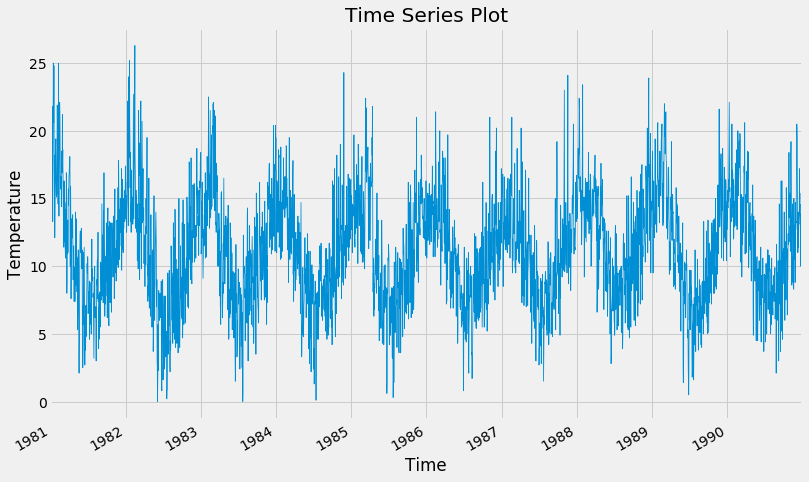

In [135]:
def plot_series(data):
    plt.figure(figsize = (12,8))
    data["Temp"].plot(linestyle='-', linewidth=0.8)
    
    plt.title("Time Series Plot")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()
    
    
plot_series(data)

## Seasonal plots

In [117]:
def seasonal_plot(time_series, season="W"):

    if season not in ["W", "M"]:
        raise ValueError
    else:
        if season == "W":
            win_size = 7
            win_map = lambda x: x.weekday()
            title = "Weakly"

        elif season == "M":
            win_size = 30
            win_map = lambda x: x.day
            title = "Monthly"

        fig = plt.figure(figsize=(12, 8))
        by_day = time_series.resample(rule="D", how="sum")

        for i in range(by_day.shape[0] // win_size + 1):
            window_values = by_day.values[i * win_size:(i + 1) * win_size]
            days = by_day.index[i * win_size:(i + 1) * win_size].map(win_map)
            if window_values.ndim == 2:
                window_values = window_values[:, 0]
            values_dict = dict(zip(window_values, days))
            values_dict = {k: v for k, v in sorted(values_dict.items(), key=lambda item: item[1])}
            days, values = list(values_dict.values()), list(values_dict.keys())
            plt.plot(days, values, marker='.', linestyle='-', linewidth=0.95)
        plt.title("{} plot".format(title))
        plt.show()


def yearly_plot(data):
    all_years = [data.index[i].year for i in range(data.shape[0])]
    
    plt.figure(figsize=(12,8))
    for year in all_years:
        temps = data[data.index.year == year]["Temp"]
        plt.plot(list(range(len(temps))),temps, linestyle='-', linewidth=0.8)
        
    plt.xlabel("Days")
    plt.ylabel("Temps")
    plt.show()

/home/garik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


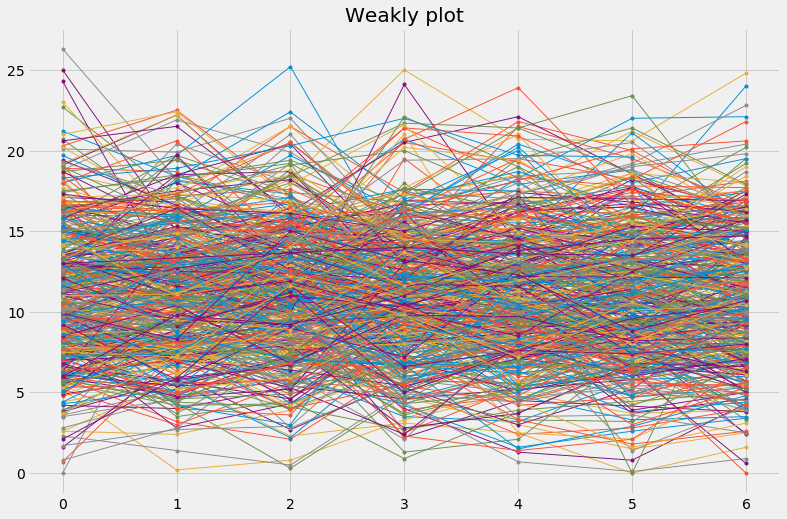

In [118]:
seasonal_plot(data,"W")

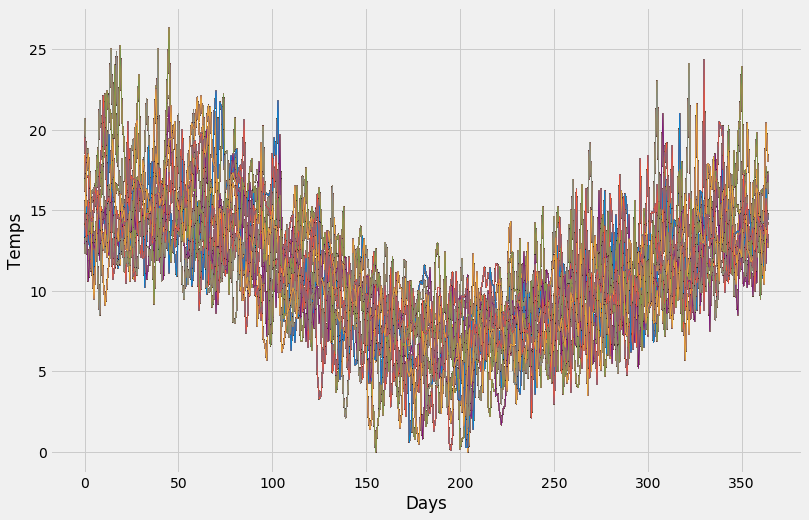

In [119]:
yearly_plot(data)

### Seasonal decomposition

We want to split a time series into 3 components: trend, seasonality and noise.

If we assume an additive decomposition, then we can write

$$y_{t} = T_{t} + S_{t} + R_{t}$$
where $y_{t}$ is the data, $S_{t}$ is the seasonal component, $T_{t}$ is the trend-cycle component, and  $R_t$ is the remainder component, all at period t. Alternatively, a multiplicative decomposition would be written as.
$$y_{t} = T_{t} * S_{t} * R_{t}$$


In [136]:
import statsmodels.api as sm 
def plot_seasonal_decomposition(data, decomposition_model="additive",freq=30):
    from pylab import rcParams
    rcParams['figure.figsize'] = 18, 8

    decomposition = sm.tsa.seasonal_decompose(data["Temp"], model=decomposition_model,freq=freq)
    fig = decomposition.plot()
    plt.show()
    return decomposition

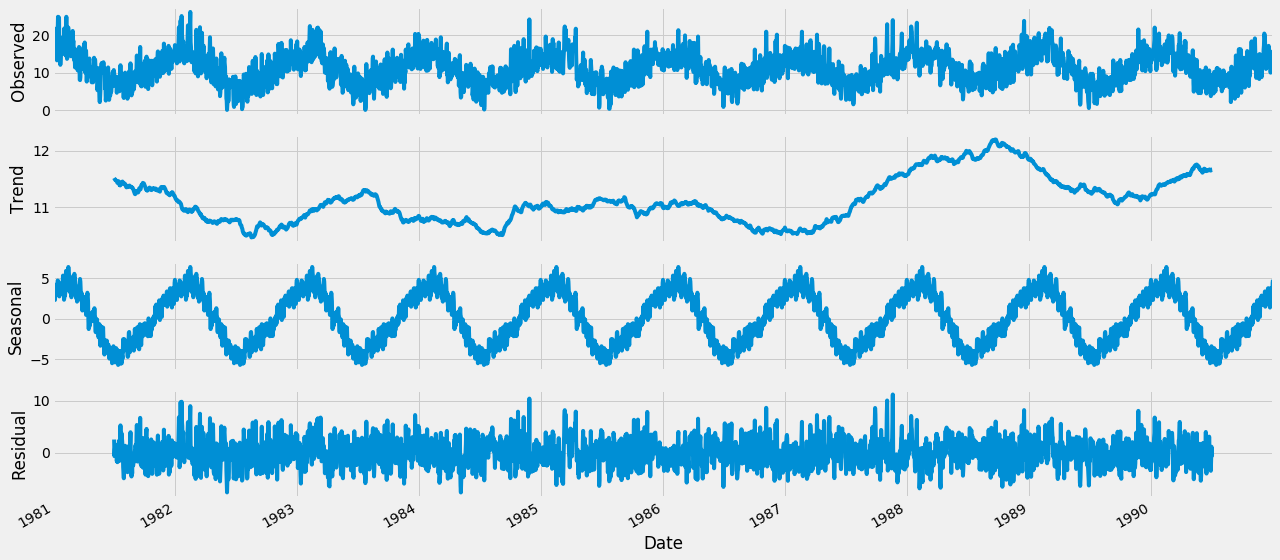

In [137]:
decomposition = plot_seasonal_decomposition(data,freq=365)

https://www.youtube.com/watch?v=PNPJ5D6vdTI

### Lag plots

Lag plots shows  $y_t$ plotted against  $y_{t+k}$ for different values of  k.

In [122]:
from pandas.plotting import lag_plot

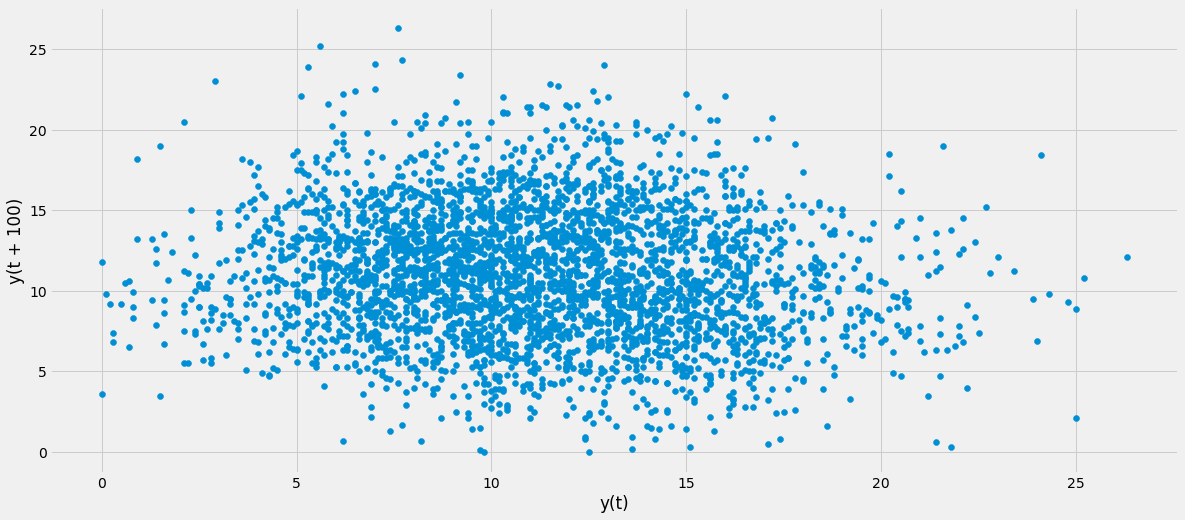

In [123]:
lag_plot(data,lag=100);

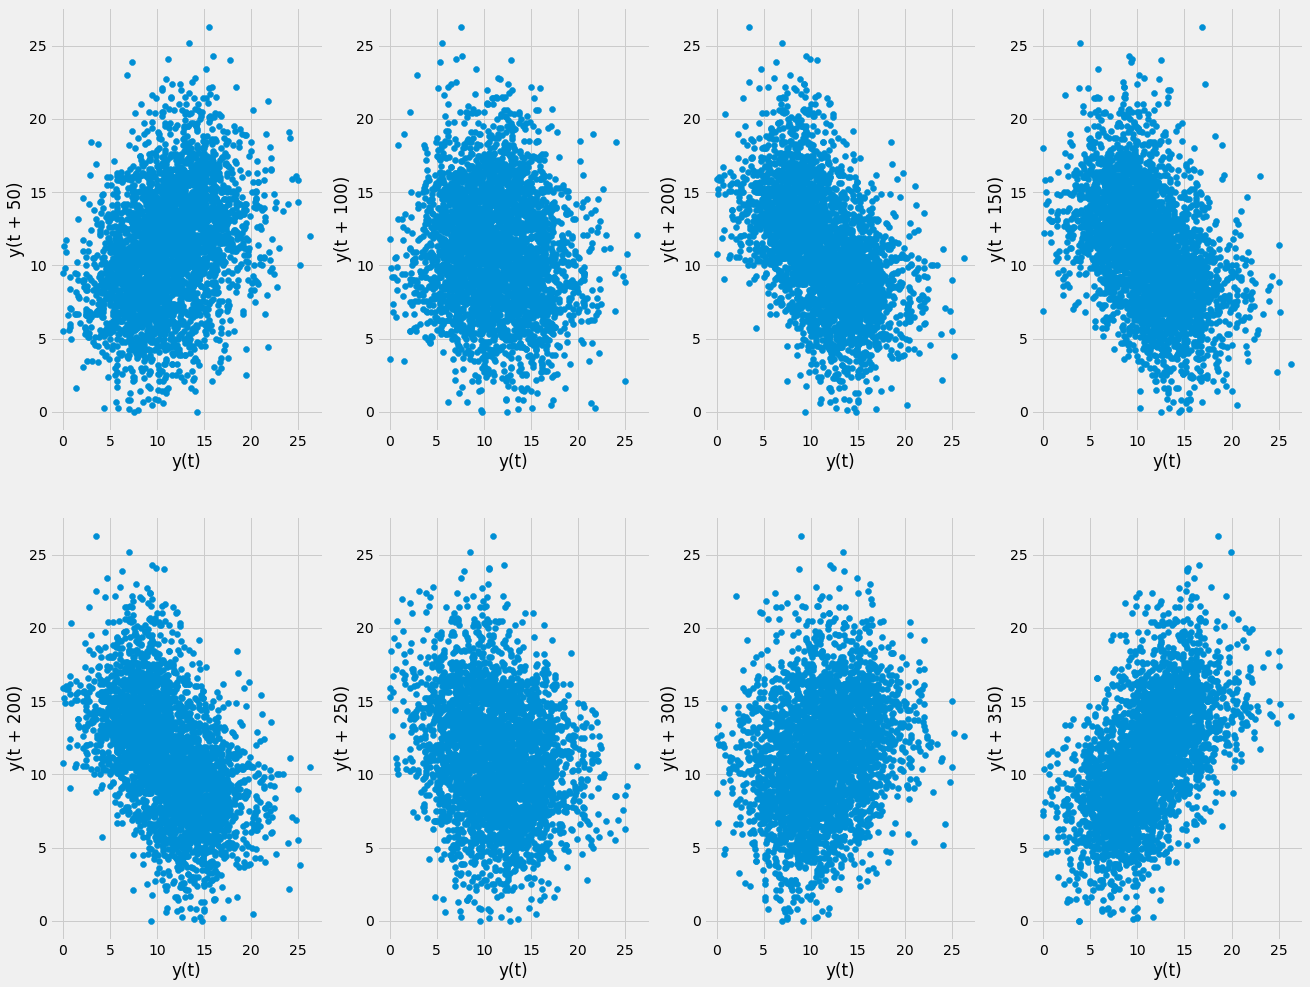

In [124]:

lags = [50,100,200,150,200,250,300,350]

n_rows,n_cols = 2, len(lags)//2
fig,ax = plt.subplots(n_rows,n_cols,figsize=(20,16))

i = 0
for row in ax:
    for col in row:         
        lag_plot(data,lag=lags[i],ax=col)
        i+=1
plt.show()
    
    

### Autocorelation 
Just as correlation measures the extent of a linear relationship between two variables, autocorrelation measures the linear relationship between lagged values of a time series.

The value of  $r_{k}$ can be written as

\begin{equation}r_{k}=\frac{\sum_{t=k+1}^{T}\left(y_{t}-\bar{y}\right)\left(y_{t-k}-\bar{y}\right)}{\sum_{t=1}^{T}\left(y_{t}-\bar{y}\right)^{2}}\end{equation}

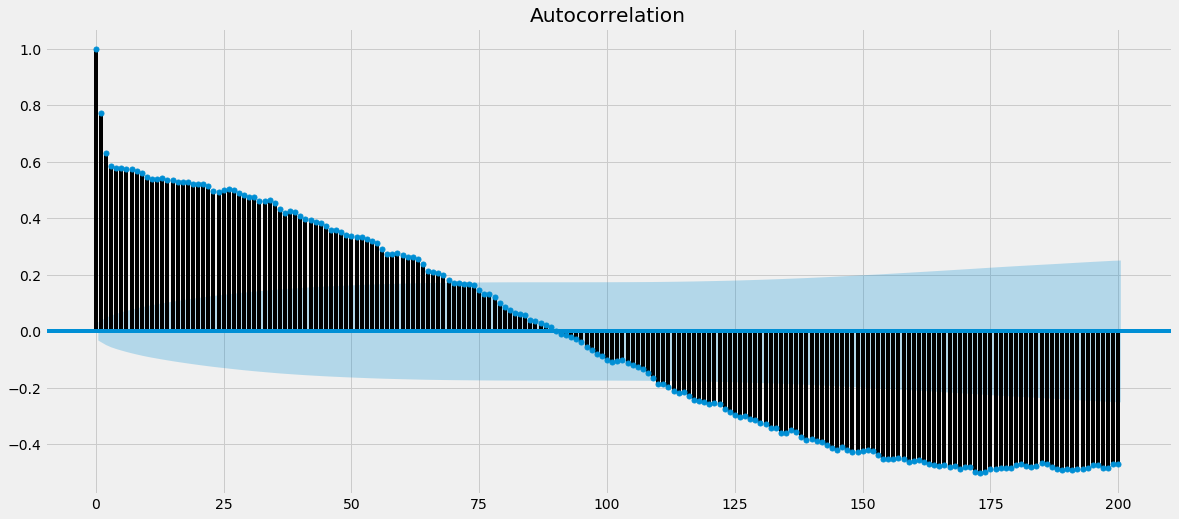

In [133]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data["Temp"],lags=200)
plt.show()

### For white noise 

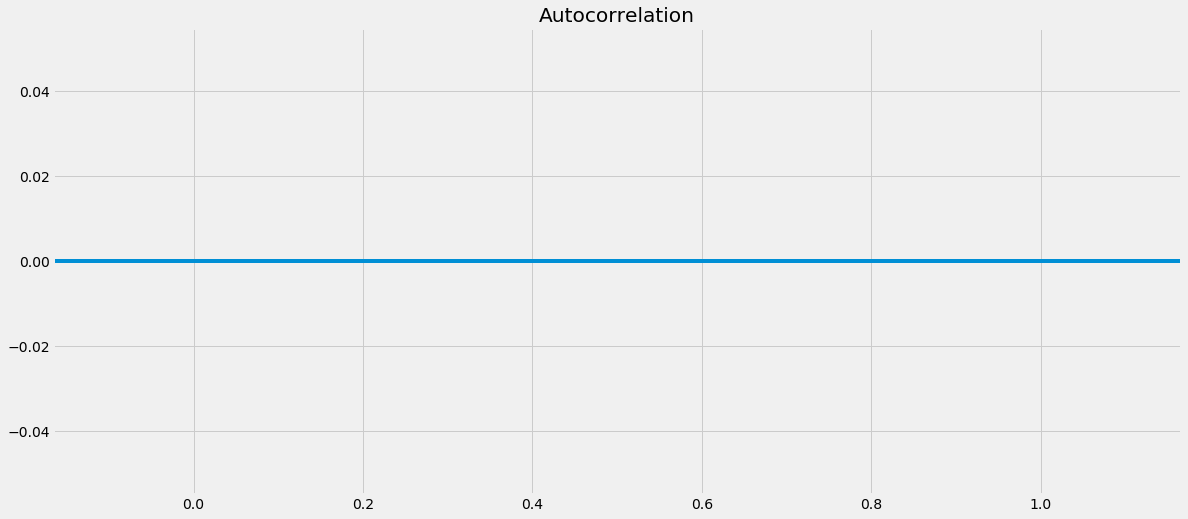

In [142]:
plot_acf(decomposition.resid)
plt.show()

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/